In [1]:
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 1.6a: 本征值分解 Eigenvalue Decomposition

*   矩阵分解可被简单理解为“在一定约束条件下，将一个矩阵化成多个矩阵乘积的过程”。
*   **本征值分解数学形式：** $M = U\Lambda U^{\dagger}$ (其中 $\dagger$ 表示取转置复共轭)，即 $M_{ac} = \sum_{b} U_{ab}\Lambda_{bb}U^{*}_{cb}$。
*   **约束条件：**（1）变换矩阵的幺正性：$U^{\dagger}U = UU^{\dagger} = I$ ；(2) $\Lambda$为对角矩阵。

![eigenvalue-decomposition-tensor-network](images/eigenvalue_decomposition_tensor_network.png)

注意对角矩阵用菱形或者实心圆点表示，两条线段其实代表同一个 index

## 本征方程的解

*   本征值分解给出**本征方程**的解，即归一化向量$v$，满足 $Mv = \gamma v$
*   $U$ 的列向量给出本征方程的解，$\Lambda$的对角元给出本征值，满足 $MU_{:,n} = \Lambda_{n,n}U_{:,n}$
*   并不是任意矩阵都存在本征值分解！
*   厄密矩阵（$M = M^{\dagger}$）一定存在本征值分解，且本征值为实数。

### 本征方程的应用
* $M$ 可以是动力学的描述，$v$ 可以是动力学的一个稳定点
* $M$ 可以是一个旋转算符，例如旋转 180 度，那么直线可以理解为是这个旋转算符的本征方程的解




In [2]:
def rand_hermitian_matrix(dim: int) -> torch.Tensor:
    H = torch.randn(dim, dim, dtype=torch.complex64)
    H = H + H.conj().t()
    return H

In [3]:
H = rand_hermitian_matrix(3)
print(f"Random Hermitian Matrix:\n{H}")

# To decompose a *Hermitian* matrix, use the `eigh` function
eigenvalues, u = torch.linalg.eigh(H)
print(f"Eigenvalues:\n{eigenvalues}")
print(f"EigenVectors:\n{u}")

reconstructed_H = u @ torch.diag(eigenvalues.to(torch.complex64)) @ u.conj().t()
error = (H - reconstructed_H).norm()
print(f"Error:\n{error}")

Random Hermitian Matrix:
tensor([[-2.7819+0.0000j,  2.0022-0.0569j,  2.1426+0.0770j],
        [ 2.0022+0.0569j, -0.3999+0.0000j, -0.1157+0.1805j],
        [ 2.1426-0.0770j, -0.1157-0.1805j, -0.7750+0.0000j]])
Eigenvalues:
tensor([-4.8606, -0.4902,  1.3940])
EigenVectors:
tensor([[ 0.8155+0.0000j, -0.0933+0.0000j, -0.5712-0.0000j],
        [-0.3775+0.0073j,  0.4377+0.5361j, -0.6104-0.0771j],
        [-0.4387-0.0011j, -0.5399-0.4700j, -0.5381+0.0752j]])
Error:
1.1915864206457627e-06


In [4]:
N = 1
# To test eigenvalue decomposition
v1 = eigenvalues[N] * u[:, N]
v2 = H @ u[:, N]
assert v1.allclose(v2)

## 本征值分解对应的优化问题

*   **本征值分解对应的优化问题**：求解归一化向量，满足 $\max_{|v|=1}(v^\dagger Mv)$，即
    * $v$ 要保证是单位向量，同时最大化 $v^\dagger Mv$
*   上述问题的解为 **M** 的最大本征值对应的 **本征向量**，$v^\dagger Mv$ 的值给出 **最大本征值** (证明过程可参考中文书1.4节)
*   考虑建立如下损失函数：
    $L = -\frac{v^\dagger Mv}{v^\dagger v}$
    * $v$ 不限制长度，所以要手动归一化
*   优化 $v$ 实现 $L$ 的极小化，即可得到 **M** 的最大本征值及对应的本征向量

### 证明：TODO

### 优化例子

In [5]:
dim = 8
lr = 2e-2
it_num = 300

# Generate a random real symmetric matrix (subset of Hermitian matrices)
mat = torch.randn(dim, dim, dtype=torch.float32)
mat = (mat + mat.t()) / 2

v = torch.randn(dim, dtype=torch.float32, requires_grad=True)
adam = torch.optim.Adam([v], lr=lr)
losses = torch.zeros(it_num, dtype=torch.float32)

for t in tqdm(range(it_num)):
    # left out conjugate since v is real
    loss = -torch.einsum("a,ab,b", v, mat, v) / v.dot(v)
    loss.backward()
    adam.step()
    adam.zero_grad()
    losses[t] = loss.item()

  0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
found_max_eigenvalues = -losses
ref_eigenvalues = torch.linalg.eigvalsh(mat)
ref_max_eigenvalue = ref_eigenvalues.max()

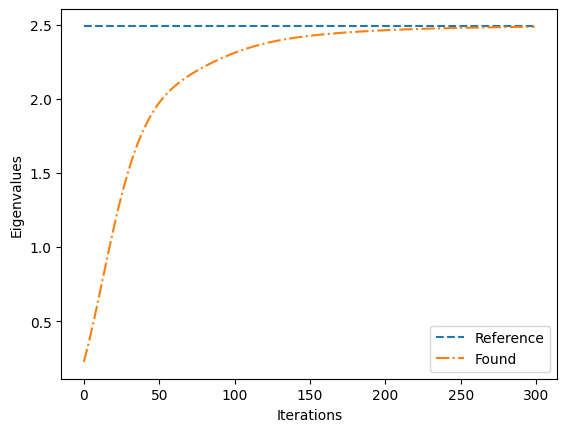

In [7]:
# plot
iterations = range(it_num)
fig, ax = plt.subplots()
ax.plot(iterations, torch.ones(it_num) * ref_max_eigenvalue, linestyle="--", label="Reference")
ax.plot(iterations, found_max_eigenvalues, linestyle="-.", label="Found")
ax.set_xlabel("Iterations")
ax.set_ylabel("Eigenvalues")
ax.legend()

### 任意线性映射的本征值分解

*   **任何线性映射**均可定义本征方程
    $f(v) = \gamma v$
*   使用scipy中的**线性算子 (LinearOperator)** 求解；
*   该方法对于复杂线性映射的处理十分有用，比如说一些线性映射的参数很少，但是如果写矩阵 $M$ 出来的话很麻烦或者很大，那么可以直接用线性算子来进行计算

In [8]:
from scipy.sparse.linalg import eigsh, LinearOperator

dim = 8
# M is a sparse real symmetric matrix, representing a linear map that has a few parameters compared to the size of the matrix
M = torch.eye(dim, dtype=torch.float32)
M[0, 7] = 1.
M[7, 0] = 1.

# Get the max eigenvalue with PyTorch
eigenvalues = torch.linalg.eigvalsh(M)
max_eigenvalue_torch = eigenvalues.max()

# Get the max eigenvalue with scipy
M_scipy = M.numpy()
eigenvalues, _ = eigsh(M_scipy, k=1, which="LA")
max_eigenvalue_scipy = eigenvalues[0]

# Get the max eigenvalue with LinearOperator
M2 = LinearOperator(shape=M_scipy.shape, matvec=lambda v: M_scipy @ v)
eigenvalues, _ = eigsh(M2, k=1, which="LA")
max_eigenvalue_linear_operator = eigenvalues[0]

print(f"torch: {max_eigenvalue_torch}, scipy: {max_eigenvalue_scipy}, LinearOperator: {max_eigenvalue_linear_operator}")

torch: 2.0, scipy: 2.0, LinearOperator: 2.0
